**Move this file to the project root directory (same as `README.md`) in order to run it.**

# Software Walkthrough

Step by step, how to simulate a magnetic electron recoil gamma spectrometer.

### Monte-Carlo $\gamma \to e^-$ Conversion Foil

First, let's define the parameters for our foil and aperture:

In [ ]:
from physical_constants import mol

R_FOIL = 0.015
L_DRIFT = 0.25
R_APERTURE = 0.015

Z = 6
x_material_name = "c"
x_density = 2.18 # [g/cm^3]
x_atomic_weight = 12.011  # [amu | g/mol]
x_depth_mm = 0.5
x_number_density = x_density * 1e6 / x_atomic_weight * mol  # [/m^3]

Firstly, prepare the data indicating how electrons slow down in our conversion foil. The data is pulled from the ESTAR database, which contains slowing information of stopping power for electrons by numerous types of material.

To use this data, we convert it into an `SRXMData`, which is a tuple of two numpy arrays of the same size (with the correct units): `(electron_energy: J, electron_slowing: J / m)`.

In [ ]:
import numpy as np
from physical_constants import MeV, centimeter
from acceptance import SRXMData

with open(f"./_data/estar_{x_material_name}.txt", "r", encoding="utf8") as srem:
    x_srem = np.array(
        [[float(y) for y in x.split(" ")[:2]] for x in srem.readlines()[9:]]
    )
    x_srem[:, 0] *= MeV  #  MeV  ->  J
    x_srem[:, 1] *= x_density * MeV / centimeter  #  MeV cm^2 / g  ->  J / m
    x_srem: SRXMData = x_srem[:, 0], x_srem[:, 1]

Then, pull in the relevant cross sections for the interaction (in this case, compton scattering and electron/positron pair production). These are pre-implemented, and so just need to be imported (to implement other cross sections, see the `creating_new_cross_section.ipynb` notebook).

The compton cross section generator function accepts material mean electron number density, as well as two arguments that set the resolution of the input photon energies and output electron angles.
The pair-production cross section generator accepts material atom number density, nucleus atomic number, and a table containing most of the cross section data pre-computed (since the calculation, as implemented, is very slow).

In [ ]:
import numpy as np
from cross_sections import gen_cross_section_compton
from cross_sections import gen_cross_section_pairproduction, load_pairproduction_cross_section
from physical_constants import MeV


x_crosssection_compton = gen_cross_section_compton(
    x_number_density * Z,
    np.linspace(2, 20, 50) * MeV,
    np.linspace(0.0, np.pi, 1000),
)

x_crosssection_pairproduction = gen_cross_section_pairproduction(
    Z,
    x_number_density,
    load_pairproduction_cross_section("./_data/pairprod_xsctn_medium.npz"),
)

These two pieces are then combined into a `Foil` object, which is a tuple of the slowing data and an array of cross sections to use (`(SRXMData, list[ CrossSection ])`).

In [ ]:
from acceptance import Foil

x_foil: Foil = x_srem, [
    x_crosssection_compton,
    x_crosssection_pairproduction,
]

This object may then be passed into `foil_trace` to actually simulate the conversion dynamics of the foil.

Now, for ease of use later on, the next two operations will be wrapped together under a single function, with all arguments in place:
- `foil_trace`: Returns the angles, energies, and interaction types of `n_rays_incident` gamma rays with energy `phot_energy_in`, through a conversion foil with given material properties and depth. (`n_srxm_steps` indicates the resolution of the numeric integral of the stopping power / slowing calculation).
- `aperture`: Filters the post_foil rays by whether they would pass through an aperture with the given parameters (`R_FOIL`: the radius (meters) of the foil, where electron rays are created, `R_APERTURE`: the radius (meters) of the aperture, that electrons are permitted to pass through, `L_DRIFT` the parallel distance (meters) between the foil and aperture that electrons must travel).

In [ ]:
from physical_constants import millimeter
from acceptance import foil_trace, aperture

def do_monte_carlo(
    gamma_energy: float,
    n_rays_incident: int,
):
    post_foil = foil_trace(
        n_rays_incident=n_rays_incident,
        n_srxm_steps=100, # resolution of electron slowing calculation
        phot_energy_in=gamma_energy,
        foil_properties=x_foil,
        foil_depth=x_depth_mm * millimeter,
    )
    post_aperture = aperture(post_foil, R_FOIL, R_APERTURE, L_DRIFT)
    return post_foil, post_aperture

One may use the outputs of the above to do some helpful logging to visualize how the foil behaves:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from acceptance import AngleEnergyId, ThetaPhiXYEnergyId
from physical_constants import MeV

def do_plots__(
    gamma_energy: float,
    n_rays_incident: int,
    post_foil: AngleEnergyId,
    post_aperture: ThetaPhiXYEnergyId,
):
    elec_angle, elec_energy, ids = post_foil
    t, p, x, y, en, i = post_aperture

    plt.hist2d(elec_angle, elec_energy / MeV, bins=150)
    plt.title(
        f"{x_material_name[0].upper()}{x_material_name[1:]} {x_depth_mm}mm, for {gamma_energy/MeV}MeV gamma"
    )
    plt.xlabel("electron angle /rad")
    plt.ylabel("electron energy /MeV")
    plt.show()
    # plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=250, stacked=True)
    plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=int(16 / 0.150), stacked=True)
    plt.title(
        f"post-aperture electron energy, for {gamma_energy/MeV}MeV gamma\n[{x_material_name[0].upper()}{x_material_name[1:]} {x_depth_mm}mm; foil r={R_FOIL/0.01}cm, drift {L_DRIFT/0.01}cm, aperture r={R_APERTURE}]"
    )
    plt.legend(["compton", "pair production"])
    plt.xlabel("electron energy /MeV")
    plt.ylabel("counts")
    plt.show()


def do_logs__(
    gamma_energy: float,
    n_rays_incident: int,
    post_foil: AngleEnergyId,
    post_aperture: ThetaPhiXYEnergyId,
):
    elec_angle, elec_energy, ids = post_foil
    t, p, x, y, en, i = post_aperture

    print(
        f"------ {x_material_name} {x_depth_mm}mm, gamma energy: {gamma_energy/MeV} MeV ------"
    )
    print(f"compton conversion efficiency: {(ids == 0).sum() / n_rays_incident}")
    print(f"pair production efficiency: {(ids==1).sum() / n_rays_incident}")

    foil_area = 3.14159 * (R_FOIL / 1e-2) ** 2
    gamma_per_cm2_MW = 1.5e3

    print(
        f"post-aperture efficiency: {en.size / n_rays_incident}  [1/{n_rays_incident / en.size }]"
    )
    print(
        f"electrons per megawatt: {(en.size / n_rays_incident) * gamma_per_cm2_MW * foil_area}"
    )
    print(
        f"electrons @140MW: {(en.size / n_rays_incident) * gamma_per_cm2_MW * foil_area * 140}"
    )
    print(
        f"post-aperture efficiency [compton only]: {en[i==0].size / n_rays_incident}  [1/{n_rays_incident / en[i==0].size }]"
    )
    print(
        f"electrons per megawatt [compton only]: {(en[i==0].size / n_rays_incident) * gamma_per_cm2_MW * foil_area}"
    )
    print(
        f"electrons @140MW [compton only]: {(en[i==0].size / n_rays_incident) * gamma_per_cm2_MW * foil_area * 140}"
    )

    print(
        f"[{np.min(en[i==0])/MeV} : {np.max(en[i==0])/MeV}] [{np.min(en[i==1])/MeV} : {np.max(en[i==1])/MeV}]"
    )

------ c 0.5mm, gamma energy: 5.0 MeV ------
compton conversion efficiency: 0.0022169
pair production efficiency: 0.0002031
post-aperture efficiency: 0.0001745  [1/5730.659025787965]
electrons per megawatt: 1.8502001606250003
electrons @140MW: 259.02802248750004
post-aperture efficiency [compton only]: 0.0001588  [1/6297.229219143577]
electrons per megawatt [compton only]: 1.6837351605000002
electrons @140MW [compton only]: 235.72292247000001
[4.24706469957291 : 4.7561227343093995] [0.25979784562589336 : 3.7001728966678398]


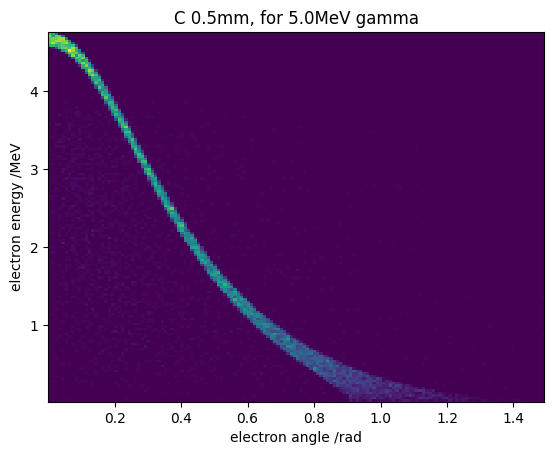

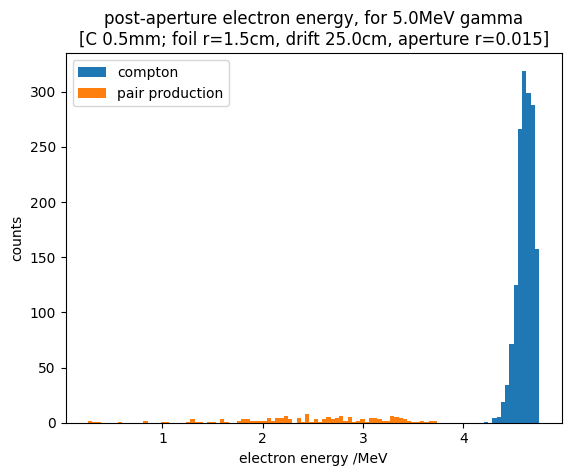

In [ ]:
in_gamma_energy = 5 * MeV
in_gamma_number = 10_000_000
_output_foil, _output_aperture = do_monte_carlo(in_gamma_energy, in_gamma_number)
do_logs__(in_gamma_energy, in_gamma_number, _output_foil, _output_aperture)
do_plots__(in_gamma_energy, in_gamma_number, _output_foil, _output_aperture)

## Magnetic Optics

The magnetic optics of this system are handled by COSY Infinity (see `/README.md`, https://www.bmtdynamics.org/cosy/), with a wapper written in python (in the `/cosy/__init__.py` module), and some pre-implemented spectrometer-design-specific tooling (in the `mrs_ion_optics.py` module).

With COSY correctly installed, using the python wrapper and toolkit mostly involves the `MRSIonOptics` class.

Firstly, an ion optics session (`sess`) will be started by calling `MRSIonOptics`'s constructor, and then configured:
- `disable_fit`: disables parameter optimization / fitting for this session (can be re-enabled with later calls to `config_fit`)
- `config_order(1)`: sets the order of the ion optics to 1 (linear), (related to the order of a taylor expansion).

In [ ]:
from mrs_ion_optics import MRSIonOptics

sess = MRSIonOptics().disable_fit().config_order(1)

The session can be further configured by setting the parameters of the magnets, using `set_parameters`, which sets all the parameters at once (as opposed to `set_parameter`, which just sets one).

In [ ]:
import mrs_ion_optics as K

sess.set_parameters(
    {
        K.K_p_bend_radius: 0.55,
        K.K_p_bend_angle: 110.0,
        K.K_p_drift_post_aperture: 0.05,
        K.K_p_drift_pre_bend: 0.1711294047732842,
        K.K_p_drift_post_bend: 0.2014765625,
        K.K_p_drift_pre_hodoscope: 0.228115896571998,
        K.K_p_m5a_length: 0.1,
        K.K_p_m5a_quad: -0.06233481854188321,
        K.K_p_m5a_hex: 0.0,
        K.K_p_m5a_oct: 0.0,
        K.K_p_m5a_dec: 0.0,
        K.K_p_m5a_dodec: 0.0,
        K.K_p_m5b_length: 0.1,
        K.K_p_m5b_quad: 0.115469210096311,
        K.K_p_m5b_hex: 0.0,
        K.K_p_m5b_oct: 0.0,
        K.K_p_m5b_dec: 0.0,
        K.K_p_m5b_dodec: 0.0,
        K.K_p_shape_in_1: 0.2985833653414149,
        K.K_p_shape_in_2: 0.0,
        K.K_p_shape_in_3: 0.0,
        K.K_p_shape_in_4: 0.0,
        K.K_p_shape_in_5: 0.0,
        K.K_p_shape_out_1: 0.176719510472977,
        K.K_p_shape_out_2: 0.0,
        K.K_p_shape_out_3: 0.0,
        K.K_p_shape_out_4: 0.0,
        K.K_p_shape_out_5: 0.0,
        K.K_p_drift_m5a_m5b: 0.1,
        K.K_p_m5c_length: 0.1,
        K.K_p_m5c_quad: -0.01585503500342181,
        K.K_p_m5c_hex: 0.0,
        K.K_p_m5c_oct: 0.0,
        K.K_p_m5c_dec: 0.0,
        K.K_p_m5c_dodec: 0.0,
        K.K_p_drift_m5c_m5d: 0.1,
        K.K_p_m5d_length: 0.1,
        K.K_p_m5d_quad: -0.5,
        K.K_p_m5d_hex: 0.0,
        K.K_p_m5d_oct: 0.0,
        K.K_p_m5d_dec: 0.0,
        K.K_p_m5d_dodec: 0.0,
    }
)

Additionally, the spectrometer can be visualized. `set_rays`, `add_rays` and `gen_charictaristic_rays` are used to set a bunch of test electron rays, to be visualized.
Using `exec_svg` outputs a pair of SVG images of the spectrometer and the rays it transports, which may then be rendered using jupyter's `SVG`, and `display_svg` as follows.

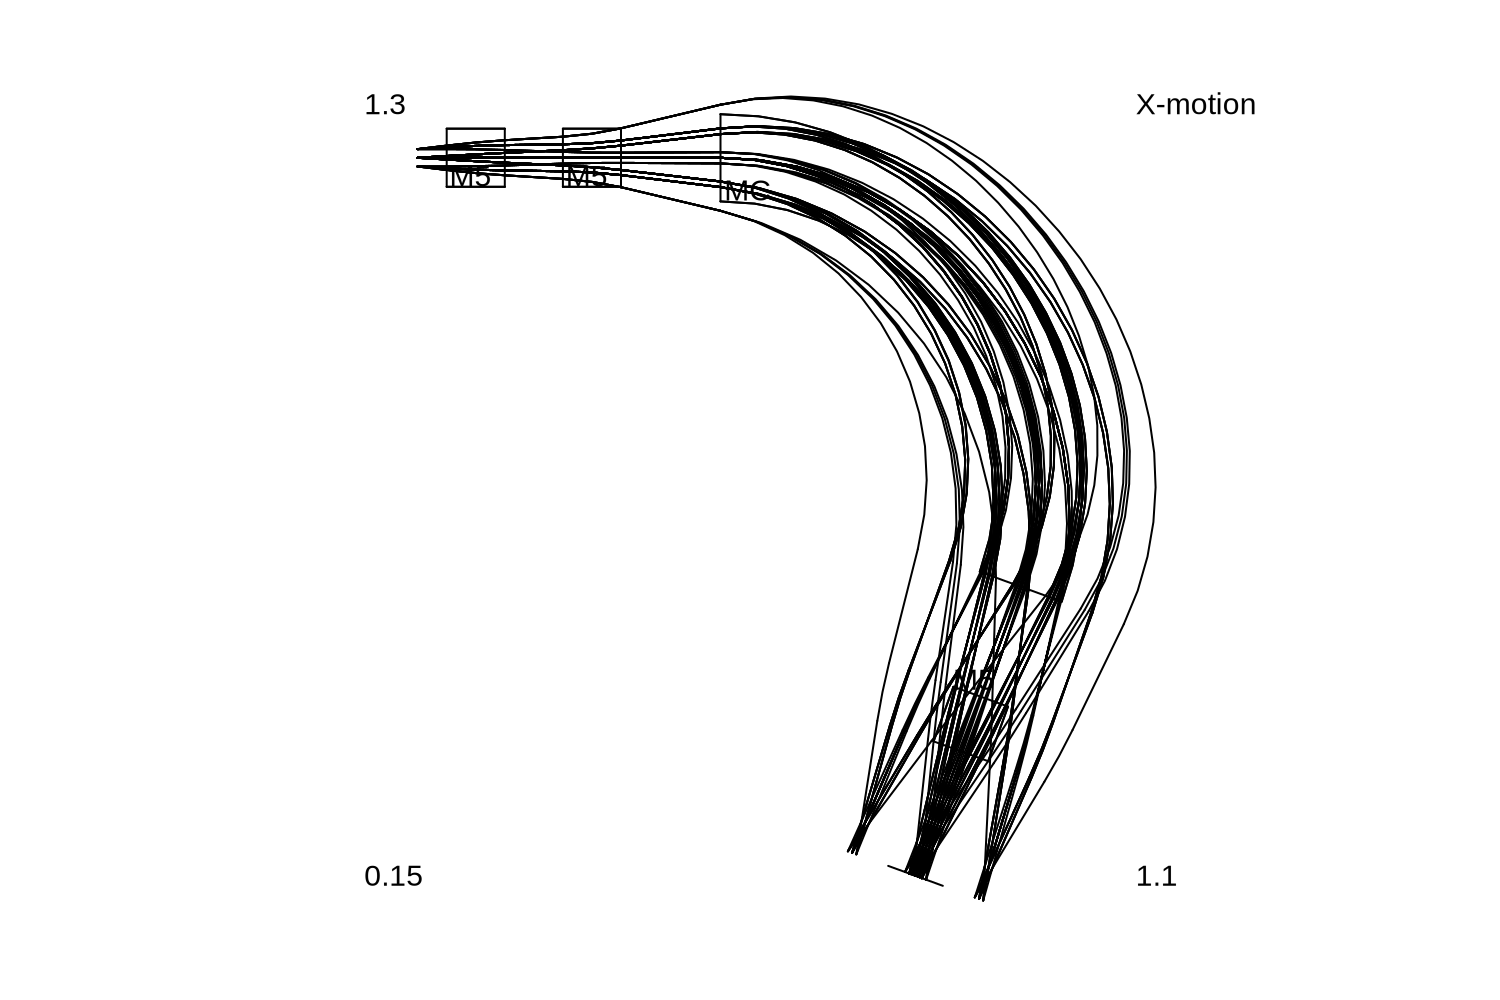

In [ ]:
from IPython.core.display import SVG, display_svg
from mrs_ion_optics import gen_charictaristic_rays

(sess
    .set_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3), color=6)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=-0.1), color=8)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=0.1), color=7)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=-0.01), color=3)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=0.01), color=2)
)

display_svg(
    SVG(data=sess.config_vis_lab_coordinates(True).config_order(1).exec_svg()[0])
)

Output parameters such as the ion-optical properties can be configured with `config_outputs`, which injects COSYScript code into the `mrs_ion_optics.fox` program, and after execution reports its value to python.
The following code gets the $(x|x)$, and $(x|a)$ parameters of the ion-optical transfer map (ie. first order magnification and focus), which is then destructured from the output of `sess.exec()` and printed.

(Note: COSYScript code passed to config_outputs may not contain spaces, due to restrictions of the COSYScript language.)

In [ ]:
import numpy as np

sess.config_outputs([
    "ME(1,1)",  # magnification (dispersive direction)
    "ME(1,2)",  # focus (dispersive direction)
])

_, (
    V_magnification,
    V_focus,
), _, _ = sess.config_order(1).exec()
print(f"Magnification: {np.abs(V_magnification)}")
print(f"Focus: {V_focus}")

Magnification: 0.5122057050725674
Focus: -6.956046849637687e-12


Notably, output parameters may involve the locations and angles of rays in the system, by pairing uop `set_rays` and outputs that include `RAY(n)` COSYScript function calls.
The following code outputs the radius of the beam in the dispersive (horizontal) direction, then use that and the dispersion ($(x|\delta E)$) to calculate and print the spectrometer's resolution.

In [ ]:
import numpy as np
from mrs_ion_optics import gen_charictaristic_rays

sess.config_outputs([
    "ME(1,6)",  # dispersion (dispersive direction)
    "(VMAX(RAY(1))-VMIN(RAY(1)))/2",  # image size (dispersive direction)
])
sess.set_rays(
    gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3),
    color=6,
)

_, (
    V_dispersion,
    V_imagesize_x,
), _, _ = sess.config_order(1).exec()
print(f"Resolution: {np.abs(2 * V_imagesize_x / V_dispersion)}")

Resolution: 0.013227157402966231


## Combined System

Putting it all together, this code used the ray transfer map output by `sess.exec()`, in combination with the `do_monte_carlo` function defined above in order to calculate the detection locations of electrons produced by a monoenergetic gamma beam at 16MeV.

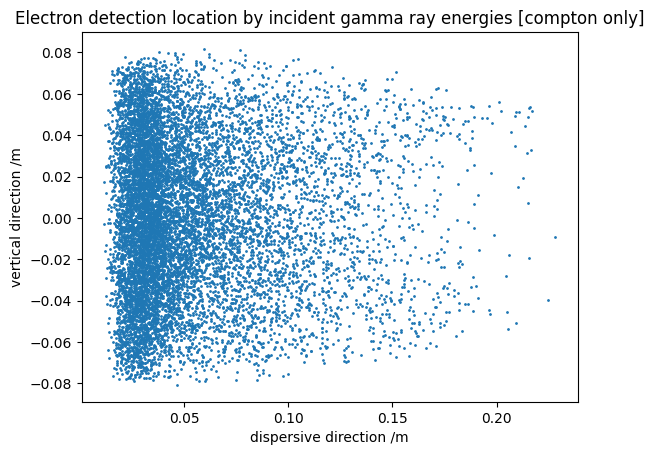

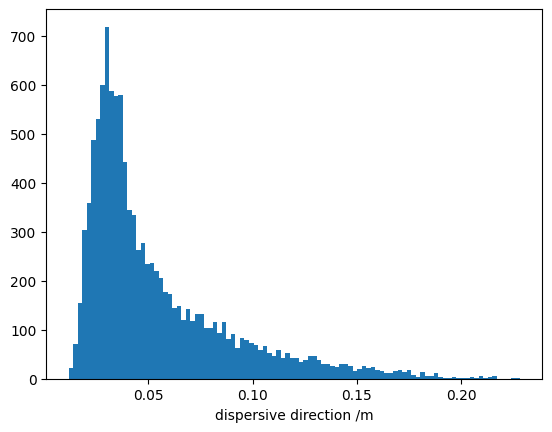

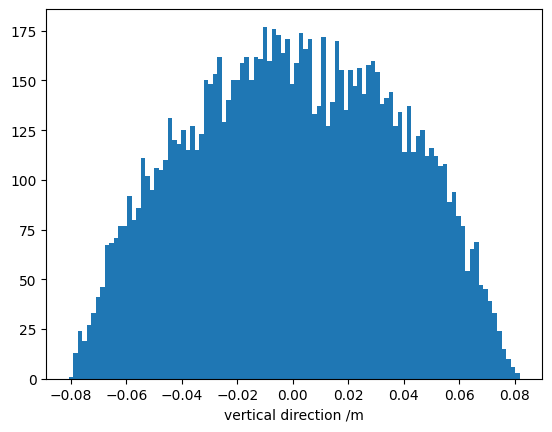

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from acceptance import rays_into_relative
from physical_constants import MeV

gamma_energy = 16 * MeV
gamma_number = 100_000_000

_, _, ray_map, _ = sess.config_order(5).exec()

NO_PAIR_PRODUCTION = True

_, rays_in_raw = do_monte_carlo(gamma_energy, gamma_number)
rays_in = rays_into_relative(rays_in_raw, gamma_energy)
if NO_PAIR_PRODUCTION:
    rays_in = rays_in[rays_in_raw[5] == 0]

rays_out = []
for x, a, y, b, e in rays_in:
    # (x,a,y,b,t,K) -> (x,a,y,b,t)
    x, a, y, b, _ = ray_map((x, a, y, b, 0, e))
    rays_out.append((x, a, y, b, e))
x, a, y, b, e = np.transpose(rays_out)

plt.scatter(x, y, s=1)
plt.xlabel("dispersive direction /m")
plt.ylabel("vertical direction /m")
plt.title(
    "Electron detection location by incident gamma ray energies [compton only]"
)
plt.show()

plt.hist(x, bins=100)
plt.xlabel("dispersive direction /m")
plt.show()

plt.hist(y, bins=100)
plt.xlabel("vertical direction /m")
plt.show()
